In [1]:
#Code borrowed from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#load data
df_train = pd.read_csv('./data/train.csv')
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
# Take 30 most relevant features from correlation matrix
k=30
corrmat = df_train.corr()
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
df_train = df_train[cols]
df_train.head()

,SalePrice,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,...,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath
0,208500,7,1710,2,548,856,856,2,8,2003,...,8450,1,150,3,0,0,2,0,0,0
1,181500,6,1262,2,460,1262,1262,2,6,1976,...,9600,0,284,3,0,0,5,0,0,1
2,223500,7,1786,2,608,920,920,2,6,2001,...,11250,1,434,3,0,0,9,0,0,0
3,140000,7,1717,3,642,756,961,1,7,1915,...,9550,1,540,3,0,0,2,0,0,0
4,250000,8,2198,3,836,1145,1145,2,9,2000,...,14260,1,490,4,0,0,12,0,0,0


In [4]:
#see missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
BsmtHalfBath,0,0.000000
Fireplaces,0,0.000000
OverallQual,0,0.000000
GrLivArea,0,0.000000
GarageCars,0,0.000000
GarageArea,0,0.000000
TotalBsmtSF,0,0.000000


In [5]:
# Remove missing data, we are not filling in values since most features are useless in this list
df_train = df_train.drop((missing_data[missing_data['Total'] > 1]).index,1)
#df_train = df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [6]:
def preprocess_features(df):
    # Get int values for categorical data
    df = pd.get_dummies(df)
    
    #Make features normal
    df['GrLivArea']  = np.log(df['GrLivArea'])
    #create column for new variable (one is enough because it's a binary categorical feature)
    #if area>0 it gets 1, for area==0 it gets 0
    df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
    df['HasBsmt'] = 0 
    df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1
    #transform data
    df.loc[df['HasBsmt']==1,'TotalBsmtSF'] = np.log(df['TotalBsmtSF'])
    
    return df
    

In [7]:
Y, X = df_train['SalePrice'], df_train.drop('SalePrice', axis=1)

In [8]:
f_cols = X.columns
X = preprocess_features(X)

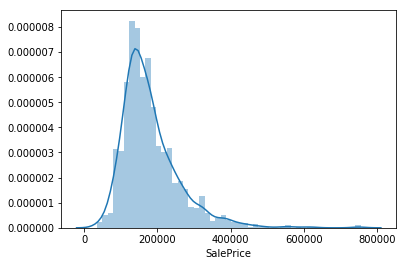

In [9]:
#histogram and normal probability plot
sns.distplot(Y);

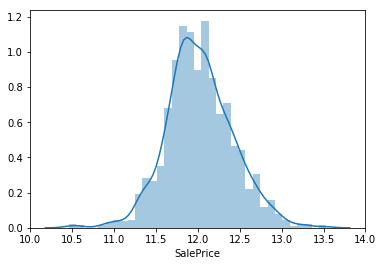

In [10]:
sns.distplot(np.log(Y))

In [11]:
Y = np.log(Y)

In [12]:
Y.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [13]:
#Validation function
n_folds = 5
from sklearn.model_selection import KFold, cross_val_score
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X.values)
    rmse= np.sqrt(-cross_val_score(model, X.values, Y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

# Define various Regression models
### Refer - https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [39]:

from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [40]:
import xgboost as xgb
# xgb Regressor
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [41]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [42]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [44]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [45]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [46]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [47]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   


In [52]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))

In [53]:
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

 Averaged base models score: 0.1840 (0.0677)



## Train Models

In [54]:
model_xgb.fit(X,Y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.4603, gamma=0.0468, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=3,
       min_child_weight=1.7817, missing=None, n_estimators=2200, n_jobs=1,
       nthread=-1, objective='reg:linear', random_state=7, reg_alpha=0.464,
       reg_lambda=0.8571, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.5213)

In [55]:
model_lgb.fit(X,Y)

LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, bagging_seed=9,
       boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       feature_fraction=0.2319, feature_fraction_seed=9,
       importance_type='split', learning_rate=0.05, max_bin=55,
       max_depth=-1, min_child_samples=20, min_child_weight=0.001,
       min_data_in_leaf=6, min_split_gain=0.0, min_sum_hessian_in_leaf=11,
       n_estimators=720, n_jobs=-1, num_leaves=5, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [56]:
averaged_models.fit(X, Y)

AveragingModels(models=(Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('elasticnet', ElasticNet(alpha=0.0005, copy_X=True, fit_intercept=True, l1_ratio=0.9,
      max_iter=1000, normalize=False, positive=False...ve=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])))

## Prepare test data

In [76]:
tdf = pd.read_csv('./data/test.csv')

In [77]:
tdf.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [78]:
#cols = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
Ids = tdf['Id']
tdf = tdf[f_cols]

In [79]:
tdf.head()

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath
0,5,896,1.0,730.0,882.0,896,1,5,1961,1961,...,11622,0.0,270.0,2,120,0,6,0,144.0,0.0
1,6,1329,1.0,312.0,1329.0,1329,1,6,1958,1958,...,14267,0.0,406.0,3,0,0,6,0,0.0,0.0
2,5,1629,2.0,482.0,928.0,928,2,6,1997,1998,...,13830,0.0,137.0,3,0,0,3,0,0.0,0.0
3,6,1604,2.0,470.0,926.0,926,2,7,1998,1998,...,9978,0.0,324.0,3,0,0,6,0,0.0,0.0
4,8,1280,2.0,506.0,1280.0,1280,2,5,1992,1992,...,5005,0.0,1017.0,2,144,0,1,0,0.0,0.0


In [80]:
#missing data
total = tdf.isnull().sum().sort_values(ascending=False)
percent = (tdf.isnull().sum()/tdf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
BsmtHalfBath,2,0.001371
BsmtFullBath,2,0.001371
GarageCars,1,0.000685
GarageArea,1,0.000685
TotalBsmtSF,1,0.000685
BsmtUnfSF,1,0.000685
BsmtFinSF2,1,0.000685
BsmtFinSF1,1,0.000685
Fireplaces,0,0.000000
GrLivArea,0,0.000000


In [81]:
tdf = tdf.fillna(tdf.mean())

In [82]:
#missing data
total = tdf.isnull().sum().sort_values(ascending=False)
percent = (tdf.isnull().sum()/tdf.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
BsmtHalfBath,0,0.0
BsmtFinSF2,0,0.0
GrLivArea,0,0.0
GarageCars,0,0.0
GarageArea,0,0.0
TotalBsmtSF,0,0.0
1stFlrSF,0,0.0
FullBath,0,0.0
TotRmsAbvGrd,0,0.0
YearBuilt,0,0.0


In [83]:
tdf = preprocess_features(tdf)
tdf.head(5)

,OverallQual,GrLivArea,GarageCars,GarageArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,YearBuilt,YearRemodAdd,...,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,ScreenPorch,PoolArea,MoSold,3SsnPorch,BsmtFinSF2,BsmtHalfBath,HasBsmt
0,5,6.797940,1.0,730.0,6.782192,896,1,5,1961,1961,...,0.0,270.0,2,120,0,6,0,144.0,0.0,1
1,6,7.192182,1.0,312.0,7.192182,1329,1,6,1958,1958,...,0.0,406.0,3,0,0,6,0,0.0,0.0,1
2,5,7.395722,2.0,482.0,6.833032,928,2,6,1997,1998,...,0.0,137.0,3,0,0,3,0,0.0,0.0,1
3,6,7.380256,2.0,470.0,6.830874,926,2,7,1998,1998,...,0.0,324.0,3,0,0,6,0,0.0,0.0,1
4,8,7.154615,2.0,506.0,7.154615,1280,2,5,1992,1992,...,0.0,1017.0,2,144,0,1,0,0.0,0.0,1


## Do Predictions for each model

In [84]:
xgb_preds = np.exp(model_xgb.predict(tdf))

In [85]:
lgb_preds = np.exp(model_lgb.predict(tdf))

In [86]:
avg_preds = np.exp(averaged_models.predict(tdf))

In [100]:
res = 0.50*avg_preds + 0.20*lgb_preds + 0.30*xgb_preds

In [101]:
df = pd.DataFrame(res)

In [102]:
df['Id'] = Ids

In [103]:
df.columns = ['SalePrice', 'Id']

In [104]:
df.head()

,SalePrice,Id
0,126270.627833,1461
1,155982.684116,1462
2,185405.184578,1463
3,193911.216327,1464
4,185793.220405,1465


In [105]:
df.to_csv('data/xgb_results_v4.csv', index=False)